In [1]:
pip install nltk spacy numpy pandas contractions seaborn tqdm matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import csv
import nltk
import spacy
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

Load_Dataset

In [6]:
import zipfile
import os

zip_file = "train_snli.txt.zip"  # Change this to your actual file name

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract files into a folder named "dataset"

print("Files extracted successfully!")


Files extracted successfully!


In [8]:
import os
import csv  
from tqdm import tqdm

In [10]:
# ✅ Update the file path based on your extraction location
file_path = "dataset/train_snli.txt"  # Change if the file is in another folder

# ✅ Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Check the directory.")

# ✅ Read data from the text file
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.readlines()

# ✅ Prepare CSV file
csv_filename = "data.csv"

with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data, desc="Processing Lines"):
        parts = line.strip().split('\t')
        
        # Ensure correct formatting
        if len(parts) != 3:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        
        source_txt = parts[0]
        plagiarism_txt = parts[1]
        
        try:
            label = int(parts[2])
        except ValueError:
            print(f"Skipping line with invalid label: {line.strip()}")
            continue
        
        writer.writerow({
            'source_txt': source_txt,
            'plagiarism_txt': plagiarism_txt,
            'label': label
        })

print("✅ CSV file created successfully: data.csv")


Processing Lines: 100%|█████████████| 367373/367373 [00:01<00:00, 320381.14it/s]

✅ CSV file created successfully: data.csv


In [12]:
df = pd.read_csv("data.csv")
df.sample(5)

,source_txt,plagiarism_txt,label
205076,A cowboy wearing a purple shirt and white hate...,A cowboy is riding a shark.,0
89303,"A rugby game being played, one man in a green ...",The rugby game was cancelled,0
49469,A firefighter is standing in his uniform holdi...,A firefighter is baking a cake.,0
239887,"Wearing a black shirt, sunglasses and a tiny s...",A drummer in black shirt and kewpie hair is st...,0
49213,A young woman wearing red shorts and t-shirt w...,the shoes are not waterproof,0


**Shape Of Data**

In [15]:
df.shape

(367373, 3)

****Check Missing Values****

**The given code identifies, removes, and verifies missing values (null values) in a Pandas DataFrame (df) to ensure data quality before further processing.**

In [18]:
# check for null values
print("Null values",df.isnull().sum())
# remove null values
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


**Checking Duplicate**

**This code checks for and removes duplicate rows in a Pandas DataFrame (df). Removing duplicates is crucial for ensuring data consistency and preventing redundancy in analysis or machine learning models**

In [21]:
# check for duplicates
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


**Check Values Count**

**code analyzes and visualizes the distribution of labels (Plagiarized vs. Not Plagiarized) in the dataset using a pie chart.**

**Helps identify imbalanced datasets, which might affect model performance.
Provides a quick visual summary of label distribution.
Assists in deciding if data balancing techniques (e.g., oversampling, undersampling) are needed.**

label
0    183874
1    183041
Name: count, dtype: int64


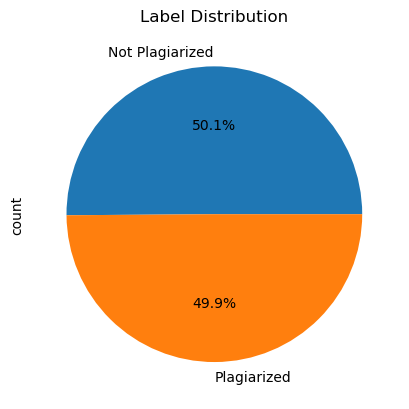

In [24]:
# check value counts
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()

**Check Text Length**

**Graph Explanation (Simple Words)
The graph shows two overlapping histograms:
Blue (original text) vs Red (plagiarized text)**

**This helps compare their word count distribution.
Dashed vertical lines show the average length:**

**If the red (plagiarized) line is shorter, it means plagiarized text tends to be shorter than the original.
If they are close together, it means both texts have similar lengths.
The shape of the graph:**

**If both distributions overlap a lot, the plagiarism is almost the same length as the original.**
**If the red curve is more shifted left, plagiarized texts are usually shorter**

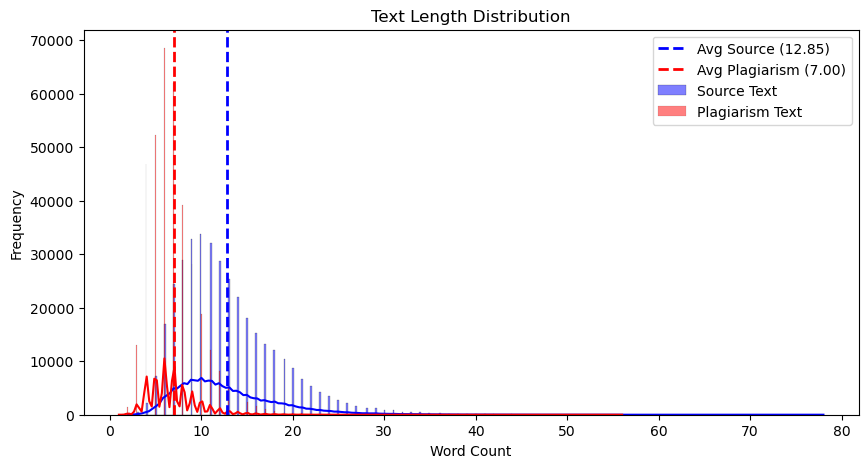

In [27]:
# Calculate source and plagiarism text lengths
df['source_len'] = df['source_txt'].apply(lambda x: len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['source_len'], color='blue', label='Source Text', kde=True)
sns.histplot(df['plagiarism_len'], color='red', label='Plagiarism Text', kde=True)

# Calculate averages
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()

# Add average lines
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')

# Final touches
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot shows the text length distribution for source and plagiarized texts. Source texts (blue) are generally longer, averaging 12.85 words, while plagiarized texts (red) are shorter, averaging 7.00 words.

Plagiarized texts are more concentrated around shorter lengths, whereas source texts have a broader distribution. This suggests that plagiarism often involves copying shorter text segments.

**WordCloud**

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

**This code generates and displays two word clouds—one for source (original) text and one for plagiarized text. A word cloud is a visual representation of text where more frequent words appear larger.**

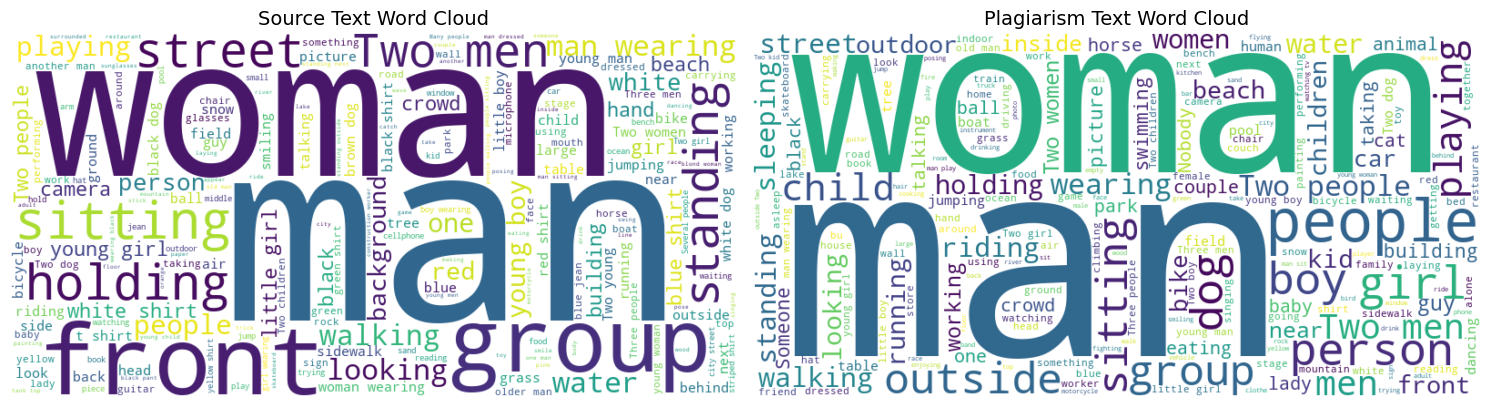

In [34]:
# ✅ Load the dataset (Ensure "data.csv" exists in the working directory)
df = pd.read_csv("data.csv")

# ✅ Check if required columns exist
if 'source_txt' not in df.columns or 'plagiarism_txt' not in df.columns:
    raise ValueError("Error: 'source_txt' or 'plagiarism_txt' column is missing in data.csv")

# ✅ Handle missing values
df = df.dropna(subset=['source_txt', 'plagiarism_txt'])

# ✅ Generate word clouds
source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)

# ✅ Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(wordcloud_source, interpolation='bilinear')
axes[0].set_title('Source Text Word Cloud', fontsize=14)
axes[0].axis('off')

axes[1].imshow(wordcloud_plag, interpolation='bilinear')
axes[1].set_title('Plagiarism Text Word Cloud', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()


**Preprocessing**
**✅ Cleans and normalizes text by removing unwanted elements (punctuation, numbers, emojis, URLs, etc.)**
**✅ Converts text to lowercase, removes stopwords, and applies lemmatization for better NLP processing**
**✅ Processes two text columns (source_txt and plagiarism_txt) and prepares them for AI-based plagiarism detection**

**This preprocessed text can now be used for machine learning, NLP models, or AI-based plagiarism detection. 🚀**

In [37]:
%%time
# ========== NLTK Downloads ==========
nltk.download('stopwords')

# ========== Load SpaCy Model for Advanced NLP Tasks ==========
nlp = spacy.load('en_core_web_sm')

# ========== 1. Lowercase ==========
def to_lowercase(text):
    return text.lower()

# ========== 2. Remove Punctuation ==========
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# ========== 3. Remove Special Characters and Numbers ==========
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)

# ========== 4. Remove HTML Tags ==========
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

# ========== 5. Remove Emojis ==========
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF" 
                               u"\U0001F680-\U0001F6FF" 
                               u"\U0001F700-\U0001F77F" 
                               u"\U0001F780-\U0001F7FF" 
                               u"\U0001F800-\U0001F8FF" 
                               u"\U0001F900-\U0001F9FF" 
                               u"\U0001FA00-\U0001FA6F" 
                               u"\U0001FA70-\U0001FAFF" 
                               u"\U00002702-\U000027B0" 
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# ========== 6. Remove URLs ==========
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# ========== 7. Remove Extra Spaces ==========
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# ========== 8. Expanding Contractions ==========
def expand_contractions(text):
    return contractions.fix(text)

# ========== 9. Stop Words Removal ==========
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

# ========== 10. Tokenization and Lemmatization (Using SpaCy) ==========
def spacy_tokenization_lemmatization(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# ========== 11. Custom Removal (Remove Specific Words) ==========
def remove_specific_words(text, words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    return " ".join(filtered_words)

# ========== Full Preprocessing Pipeline ==========
def full_pipeline(text):
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    tokens = spacy_tokenization_lemmatization(text)
    text = " ".join(tokens)
    text = remove_specific_words(text, ['chat'])  # Remove 'chat' specifically
    return text


# ========== Apply Pipeline Separately ==========
tqdm.pandas()
df['processed_source_txt'] = df['source_txt'].progress_apply(full_pipeline)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(full_pipeline)

# ========== Final Output ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'processed_plagiarism_txt']])

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/satwikojha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████████████████████████████| 367369/367369 [14:25<00:00, 424.70it/s]



========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
367368       dog blue collar play ball outside   
367369             four dirty barefooted child   
367370             four dirty barefooted child   
367371  man surf bodysuit beautiful blue water   
367372  man surf bodysuit beautiful blue water   

                      processed_plagiarism_txt  
0                  person diner order omelette  
1                        person outdoors horse  
2                                child present  
3                                    kid frown  
4                           boy skate sidewalk  
...                                        ...  
367368           

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0,person horse jump break airplane,person diner order omelette
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1,person horse jump break airplane,person outdoors horse
2,Children smiling and waving at camera,There are children present,1,child smile wave camera,child present
3,Children smiling and waving at camera,The kids are frowning,0,child smile wave camera,kid frown
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0,boy jump skateboard middle red bridge,boy skate sidewalk


In [39]:
print(df.head())  # Check if df is defined
print(df.columns)  # Ensure columns exist


                                          source_txt  \
0  A person on a horse jumps over a broken down a...   
1  A person on a horse jumps over a broken down a...   
2              Children smiling and waving at camera   
3              Children smiling and waving at camera   
4  A boy is jumping on skateboard in the middle o...   

                                  plagiarism_txt  label  \
0  A person is at a diner, ordering an omelette.      0   
1              A person is outdoors, on a horse.      1   
2                     There are children present      1   
3                          The kids are frowning      0   
4              The boy skates down the sidewalk.      0   

                    processed_source_txt     processed_plagiarism_txt  
0       person horse jump break airplane  person diner order omelette  
1       person horse jump break airplane        person outdoors horse  
2                child smile wave camera                child present  
3                chi

In [41]:
df.sample()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt
45837,A brown dog jumping over a pole.,The dog is sleeping at someone's feet.,0,brown dog jumping pole,dog sleep someone foot


In [43]:
%%time
# ========== Required Libraries ==========
from gensim.models import Word2Vec
import numpy as np

# ========== Tokenization for Word2Vec ==========
def tokenize(text):
    return text.split()

# ========== Prepare Sentences for Word2Vec ==========
source_sentences = df['processed_source_txt'].apply(tokenize).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(tokenize).tolist()

# Combine both for better context learning
all_sentences = source_sentences + plagiarism_sentences

# ========== Train Word2Vec Model ==========
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# ========== Function to Convert Sentence to Vector ==========
def sentence_to_vec(sentence, model):
    # Get vectors for words in the sentence
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    # Calculate mean of vectors to get sentence vector
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# ========== Convert Processed Text to Numeric Vectors ==========
df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))

# ========== Display Result ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'source_vec', 'processed_plagiarism_txt', 'plagiarism_vec']])



========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
367368       dog blue collar play ball outside   
367369             four dirty barefooted child   
367370             four dirty barefooted child   
367371  man surf bodysuit beautiful blue water   
367372  man surf bodysuit beautiful blue water   

                                               source_vec  \
0       [-1.2387085, -0.057188608, -0.098373614, 0.806...   
1       [-1.2387085, -0.057188608, -0.098373614, 0.806...   
2       [-0.0020712465, 0.146258, -0.16691288, 0.63480...   
3       [-0.0020712465, 0.146258, -0.16691288, 0.63480...   
4       [0.16972315, 0.027761122, 0.60633355, 0.816935.

In [45]:
!pip install tensorflow

In [60]:
df.sample()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt,source_vec,plagiarism_vec
224178,"This baseball player, dressed in red and white...",Nobody has a bat,0,baseball player dress red white uniform hold b...,nobody bat,"[0.12896739, 0.44517964, 0.3614033, 0.7101906,...","[0.74364465, 1.7337688, 0.52555585, 0.573843, ..."


In [80]:
# ========== Required Libraries for ML Model ==========
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error
import numpy as np

# ========== Ensure Vectors Are NumPy Arrays ==========
df['source_vec'] = df['source_vec'].apply(lambda x: np.array(x))
df['plagiarism_vec'] = df['plagiarism_vec'].apply(lambda x: np.array(x))

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = df['label'].values

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Train Optimized RandomForest Model ==========
clf = RandomForestClassifier(
    n_estimators=50,      # Reduced from 100 to 50 for faster training
    max_depth=10,         # Limit depth to prevent overfitting
    min_samples_split=5,  # Avoid unnecessary splits
    random_state=42,
    n_jobs=-1             # Use all CPU cores for speed
)
clf.fit(X_train, y_train)

# ========== Make Predictions ==========
y_pred = clf.predict(X_test)

# ========== Evaluate Model ==========
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n\n========= Model Evaluation =========\n")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))




========= Model Evaluation =========

Accuracy: 71.17%
MAE: 0.2883, MSE: 0.2883, RMSE: 0.5369

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.75      0.72     36586
           1       0.73      0.68      0.70     36888

    accuracy                           0.71     73474
   macro avg       0.71      0.71      0.71     73474
weighted avg       0.71      0.71      0.71     73474



In [78]:
df.sample()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt,source_vec,plagiarism_vec
212546,A white dog is in the water.,A white dog kicks sand on a child.,0,white dog water,white dog kick sand child,"[0.043916244, 0.059858967, 0.05638041, 0.00943...","[-0.19820182, 0.42667454, 0.0023888499, 0.8129..."


In [82]:
%%time

# ========== Required Libraries for LSTM Model ==========
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# ========== Reshape Data for LSTM ==========
# LSTM requires 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Early Stopping Callback ==========
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ========== Hyperparameter Tuning with Keras Tuner ==========
def build_model(hp):
    model = Sequential()

    # ========== Number of LSTM Layers ==========
    # Tune the number of LSTM layers (1 to 3 layers)
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=6, step=1)
    
    for i in range(num_layers):
        # LSTM Layer with hyperparameter tuning for units
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=128, step=32),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < num_layers - 1 else False)
        )
        
        # Dropout Layer with hyperparameter tuning for rate
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i+1}', min_value=0.2, max_value=0.5, step=0.1)))

    # ========== Dense Layer ==========
    # Dense layer with hyperparameter tuning for units and activation function
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))
    
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # ========== Optimizer and Learning Rate ==========
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optim = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    else:
        optim = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    
    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# ========== Initialize the Hyperparameter Tuner ==========
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_layers_tuning'
)

# ========== Search for the Best Hyperparameters ==========
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Get the Best Hyperparameters ==========
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"\n\nBest Hyperparameters: \n{best_hyperparameters.values}")

# ========== Build and Train the Best Model ==========
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train, y_train, initial_epoch=5, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Evaluate the Best Model ==========
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n\nBest Model Accuracy: {accuracy * 100:.2f}%")

# ========== Make Predictions ==========
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# ========== Display Classification Report ==========
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Reloading Tuner from keras_tuner/lstm_layers_tuning/tuner0.json


Best Hyperparameters: 
{'num_lstm_layers': 1, 'lstm_units_1': 128, 'dropout_rate_1': 0.2, 'dense_units': 128, 'dense_activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00017125587605581677, 'lstm_units_2': 32, 'dropout_rate_2': 0.30000000000000004, 'lstm_units_3': 96, 'dropout_rate_3': 0.4, 'lstm_units_4': 96, 'dropout_rate_4': 0.2, 'lstm_units_5': 32, 'dropout_rate_5': 0.2, 'lstm_units_6': 64, 'dropout_rate_6': 0.2, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0004'}
Epoch 6/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9185/9185 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7035 - loss: 0.5531 - val_accuracy: 0.7834 - val_loss: 0.4502
Epoch 7/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7885 - loss: 0.4450 - val_accuracy: 0.8065 - val_loss: 0.4125
Epoch 8/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8048 - loss: 0.4158 - val_accuracy: 0.8142 - val_loss: 0.3992
Epoch 9/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8165 - loss: 0.3982 - val_accuracy: 0.8223 - val_loss: 0.3865
Epoch 10/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8225 - loss: 0.3862 - val_accuracy: 0.8277 - val_loss: 0.3783
Epoch 11/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8287 - loss: 0.3760 - val_accuracy: 0.8275 - val_loss: 0.3774
Epoch 12/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8341 - loss: 0.3680 - val_accuracy: 0.8317 - val_loss: 0.3711
Epoch 13/50
9185/9185 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8384 - loss: 0.3608 -

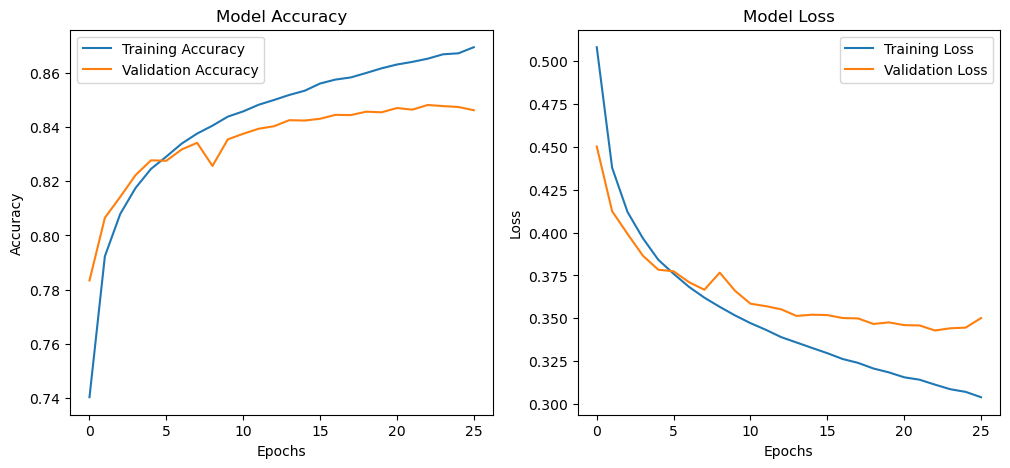

In [84]:
# ========== Plot Training History ==========
# Accuracy Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [88]:
import pickle
pickle.dump(best_model,open('best_model.pkl','wb'))
import pickle
#Save the complete Word2Vec model
pickle.dump(w2v_model, open('word2vec_model.pkl', 'wb'))